In [1]:
%matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:

first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1e6dd03bf60>,
 'prcp': 0.08,
 'station': 'USC00519397',
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1}

# Exploratory Climate Analysis

<IPython.core.display.Javascript object>


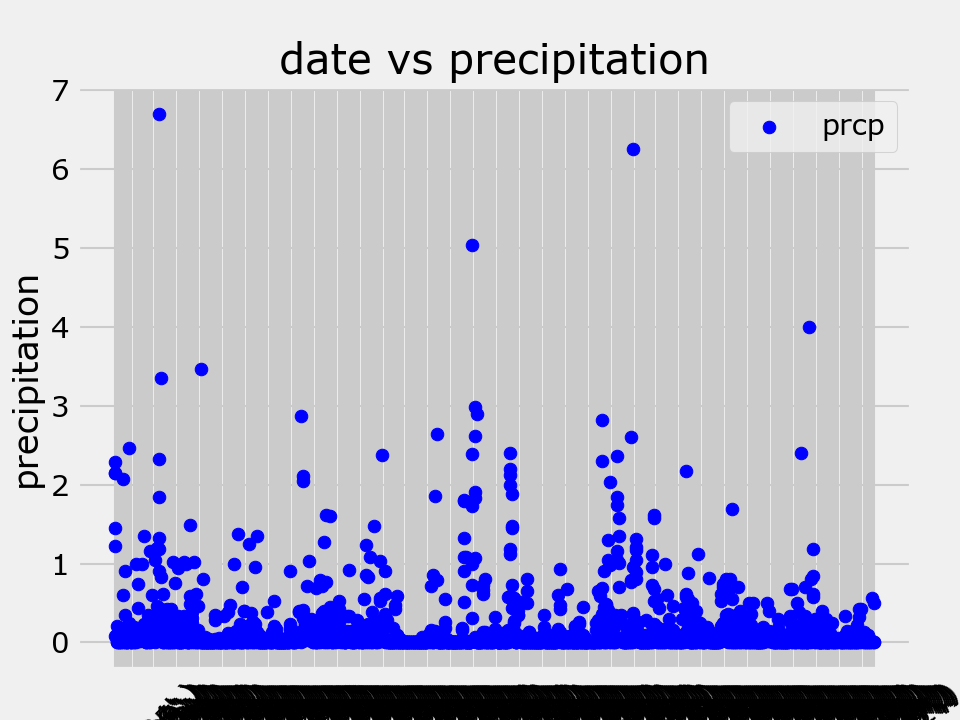

In [11]:
# Design a query to retrieve the last 12 months from 08-23-2017 of precipitation data and plot the results
# session.query(Measurement.date).filter(Measurement.date>"2017-08-23").order_by(Measurement.date).all()

dates=session.query(Measurement.date).filter(Measurement.date<"2017-08-23")\
.filter(Measurement.date>"2016-08-23").order_by(Measurement.date).all()

# Calculate the date 1 year ago from today
year_ago=dt.date.today()-dt.timedelta(days=365)
year_ago

# Perform a query to retrieve the data and precipitation scores
prec=session.query(Measurement.prcp).filter(Measurement.date<"2017-08-23")\
.filter(Measurement.date>"2016-08-23").order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
both=session.query(Measurement.date, Measurement.prcp).filter(Measurement.date<"2017-08-23")\
.filter(Measurement.date>"2016-08-23").order_by(Measurement.date).all()

df=pd.DataFrame(both)
df
# Sort the dataframe by date
df= df.sort_values(by=["date"])
df

# Use Pandas Plotting with Matplotlib to plot the data
x=[str(xdata) for xdata in dates]
date_prcp =plt.scatter(x,df["prcp"], marker="o", facecolors="blue")
date_prcp =plt.xlabel("date")
date_prcp =plt.ylabel("precipitation")
date_prcp =plt.title("date vs precipitation")
date_prcp =plt.legend()

# Rotate the xticks for the dates
date_prcp =plt.xticks(rotation=45)

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
summary_prcp=df["prcp"].describe()
summary_prcp


count    2011.000000
mean        0.176549
std         0.460667
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64

In [13]:
# How many stations are available in this dataset?
stations=session.query(func.count(Station.station)).all()
stations

[(9)]

In [14]:
# What are the most active stations?
# List the stations and the counts in descending order.
station=session.query(Measurement.station,func.count(Measurement.station))\
.group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
temp=session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).filter(Measurement.date<"2017-08-23")\
.filter(Measurement.date>"2016-08-23").all()
temp

[(58.0, 87.0, 74.56872465074358)]

<IPython.core.display.Javascript object>


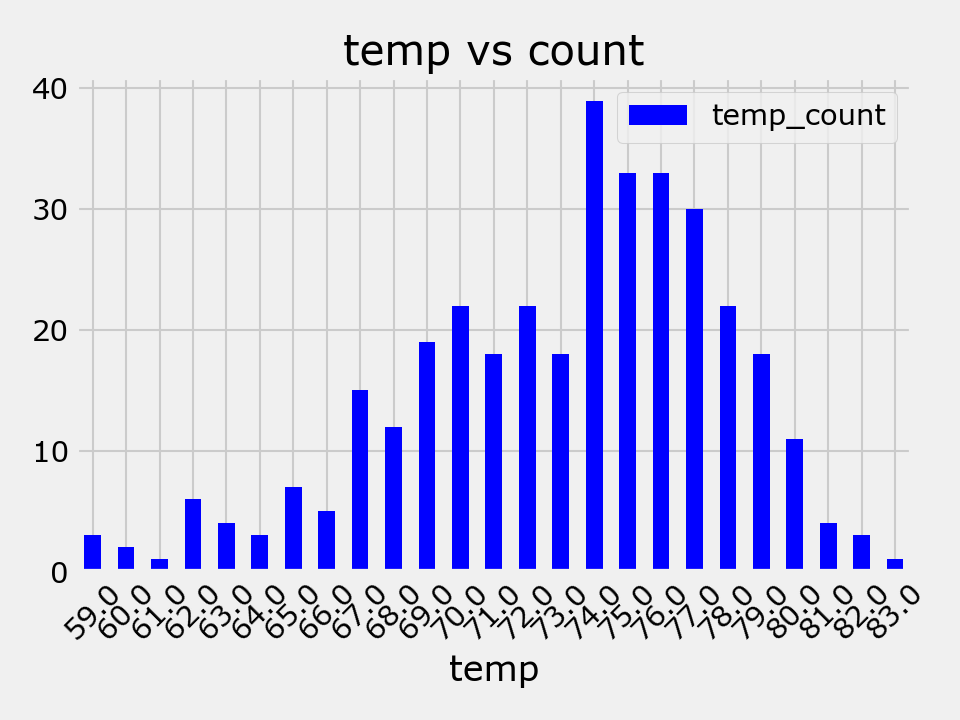

In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
highest=session.query(Measurement.station)\
.group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
highest=highest[0]
highest

temp12=session.query(Measurement.tobs,func.count(Measurement.tobs)).filter(Measurement.station=="USC00519281")\
.filter(Measurement.date<"2017-08-23")\
.filter(Measurement.date>"2016-08-23").group_by(Measurement.tobs).all()
temp12

dftemp=pd.DataFrame(temp12, columns=["temp","temp_count"])
dftemp
tempbar= dftemp.plot.bar(x="temp", y="temp_count",title="temp vs count", color="blue")
dftemp=plt.xticks(rotation=45)
dftem= plt.tight_layout()

In [24]:
temp12

[(59.0, 3),
 (60.0, 2),
 (61.0, 1),
 (62.0, 6),
 (63.0, 4),
 (64.0, 3),
 (65.0, 7),
 (66.0, 5),
 (67.0, 15),
 (68.0, 12),
 (69.0, 19),
 (70.0, 22),
 (71.0, 18),
 (72.0, 22),
 (73.0, 18),
 (74.0, 39),
 (75.0, 33),
 (76.0, 33),
 (77.0, 30),
 (78.0, 22),
 (79.0, 18),
 (80.0, 11),
 (81.0, 4),
 (82.0, 3),
 (83.0, 1)]

In [17]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [18]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
mytrip=calc_temps("2017-02-10","2017-03-10")
calc_temps("2017-02-10","2017-03-10")

[(61.0, 70.57777777777778, 80.0)]

<IPython.core.display.Javascript object>


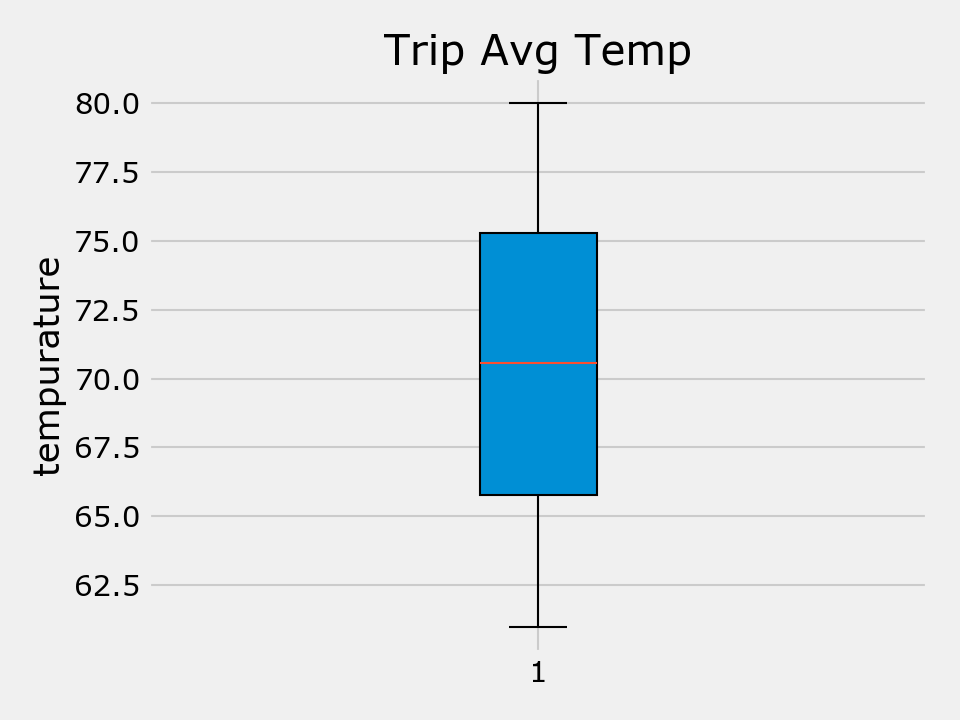

In [19]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig, ax = plt.subplots()
x = range(len(mytrip))
ax.boxplot(mytrip, patch_artist=True)
ax.set_title('Trip Avg Temp')
ax.set_ylabel("tempurature")
fig.tight_layout()
plt.show()

In [20]:
mytriprain=session.query(Measurement.date,Measurement.station,Station.name,Measurement.id,Measurement.tobs,Measurement.prcp).filter(Measurement.date<"2016-03-10")\
.filter(Measurement.date>"2016-02-10").order_by(Measurement.date).all()
mytriprain


[('2016-02-11', 'USC00519397', 'WAIKIKI 717.2, HI US', 2170, 62.0, 0.0),
 ('2016-02-11', 'USC00519397', 'KANEOHE 838.1, HI US', 2170, 62.0, 0.0),
 ('2016-02-11',
  'USC00519397',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  2170,
  62.0,
  0.0),
 ('2016-02-11', 'USC00519397', 'PEARL CITY, HI US', 2170, 62.0, 0.0),
 ('2016-02-11', 'USC00519397', 'UPPER WAHIAWA 874.3, HI US', 2170, 62.0, 0.0),
 ('2016-02-11',
  'USC00519397',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  2170,
  62.0,
  0.0),
 ('2016-02-11', 'USC00519397', 'WAIHEE 837.5, HI US', 2170, 62.0, 0.0),
 ('2016-02-11',
  'USC00519397',
  'HONOLULU OBSERVATORY 702.2, HI US',
  2170,
  62.0,
  0.0),
 ('2016-02-11',
  'USC00519397',
  'MANOA LYON ARBO 785.2, HI US',
  2170,
  62.0,
  0.0),
 ('2016-02-11', 'USC00513117', 'WAIKIKI 717.2, HI US', 4897, 72.0, 0.0),
 ('2016-02-11', 'USC00513117', 'KANEOHE 838.1, HI US', 4897, 72.0, 0.0),
 ('2016-02-11',
  'USC00513117',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  4897,
  72.0,
  0.0),
 

In [21]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [22]:
from werkzeug.wrappers import Request, Response
from flask import Flask, jsonify
app = Flask(__name__)

In [23]:
session.query(Measurement.tobs).filter(Measurement.date==year_ago).all()

[]

In [ ]:
@app.route("/")
def index():
    return "Hello, choose from<br>/api/v1.0/precipitation<br>/api/v1.0/stations<br>/api/v1.0/tobs<br>/api/v1.0/<start><br>/api/v1.0/<start>/<end>"

@app.route("/api/v1.0/start")
def start():

@app.route("/api/v1.0/end")
def end():
    
@app.route("/api/v1.0/precipitation")
def precipitation():

    return jsonify()

#done
@app.route("/api/v1.0/stations")
def stations():
    return jsonify(station)
 
#done
@app.route("/api/v1.0/tobs")
def tobs():
    tempforlast=session.query(Measurement.tobs).filter(Measurement.date==year_ago).all()
    
    
    

In [ ]:
if __name__ == '__main__':
#     app.run(debug=True)
    from werkzeug.serving import run_simple
    run_simple('localhost', 5000, app)

## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


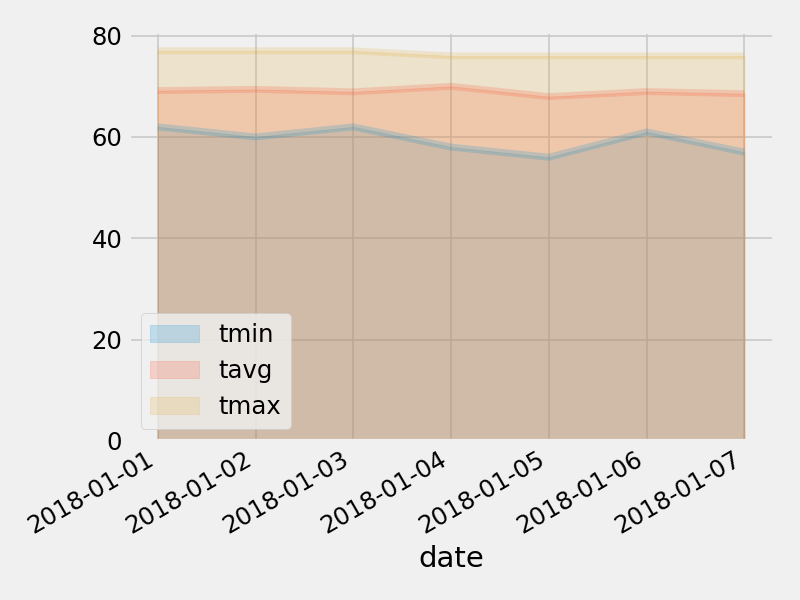

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
